<a href="https://colab.research.google.com/github/kaleeswaranm/MaskTrack/blob/main/MaskTrackTrainTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir data
!unzip /content/drive/MyDrive/stryker/DAVIS2017-master.zip -d /content/data
!unzip /content/drive/MyDrive/stryker/train_data_updated.zip -d /content
!unzip /content/drive/MyDrive/stryker/val_data.zip -d /content
!cp /content/drive/MyDrive/stryker/train_data_updated.csv /content
!cp /content/drive/MyDrive/stryker/val_data.csv /content
!cp /content/drive/MyDrive/stryker/model-0003-0.276.h5 /content

In [187]:
#for image processing
import cv2
import matplotlib.pyplot as plt
from IPython.display import Image
import imageio

#for working with paths
import glob
import os

#for array and numeric operations
import numpy as np

#for model train test
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import *
import tensorflow as tf

#misc
from tqdm import tqdm
import random
import pandas as pd

In [4]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""

    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [5]:
def get_unet(image_size = (512, 512, 3), mask_size = (512, 512, 1), n_filters = 32, dropout = 0.5, batchnorm = True):
    """Function to define the UNET Model"""

    image_input = Input(shape=image_size)
    mask_input = Input(shape=mask_size)
    inputs = Concatenate(axis=-1)([image_input, mask_input])

    c1 = conv2d_block(inputs, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[image_input, mask_input], outputs=[outputs])
    
    return model

In [6]:
def get_unique(img):
  a = np.copy(img)
  h, w, c = a.shape
  a = a.reshape((h * w, c))
  unique, counts = np.unique(a, return_counts=True, axis=0)
  return unique

In [7]:
def get_individual_masks_updated(unique, img):
  individual_masks = []
  for unique_pixel in unique:
    if not (unique_pixel == np.array([0, 0, 0])).all():
      copy_image = img.copy()
      idx = np.where((copy_image != unique_pixel).any(axis=-1))
      copy_image[idx[0], idx[1], :] = np.array([0, 0, 0], dtype=np.uint8)
      individual_masks.append(copy_image)
  return individual_masks

In [8]:
def convert_mask_updated(mask):
  arr_2d = np.ones((mask.shape[0], mask.shape[1]), dtype=np.uint8)
  idx = np.argwhere((mask == np.array([0, 0, 0])).all(axis=-1))
  arr_2d[(idx[:,0]), idx[:,1]] = 0
  return arr_2d

In [9]:
def horizontal_shift(img, x_size, y_size):
  rint = random.randint(0, 10)
  move_pixels = int(rint * 0.01 * x_size)
  num_rows, num_cols = img.shape[:2]
  l_or_r = random.randint(0, 1)
  if l_or_r == 0:
    translation_matrix = np.float32([[1,0,-1 * move_pixels], [0,1,0]])
  else:
    translation_matrix = np.float32([[1,0,move_pixels], [0,1,0]])
  aug_img = cv2.warpAffine(img, translation_matrix, (num_cols,num_rows))
  return aug_img

In [10]:
def thin_plate_splines(img):
  N=5
  points=[]
  dx=int(180/(N-1))
  for i in range(2*N):
      points.append((dx*i,4))
      points.append((dx*i,36))
  # Widen a circle around
  img = cv2.copyMakeBorder(img,4,4,0,0,cv2.BORDER_REPLICATE)

  tps = cv2.createThinPlateSplineShapeTransformer()

  sourceshape = np.array(points,np.int32)
  sourceshape=sourceshape.reshape(1,-1,2)
  matches =[]
  for i in range(1,N+1):
      matches.append(cv2.DMatch(i,i,0))

  # Start random changes
  newpoints=[]
  PADDINGSIZ=5
  for i in range(N):
      nx=points[i][0]+random.randint(0,PADDINGSIZ)-PADDINGSIZ/2
      ny=points[i][1]+random.randint(0,PADDINGSIZ)-PADDINGSIZ/2
      newpoints.append((nx,ny))
  #print(points,newpoints)
  targetshape = np.array(newpoints,np.int32)
  targetshape=targetshape.reshape(1,-1,2)
  tps.estimateTransformation(sourceshape,targetshape,matches)
  img=tps.warpImage(img)
  return img

In [11]:
def dilation(img):
  kernel = np.ones((5,5), np.uint8)
  aug_img = cv2.dilate(img, kernel, iterations=1)
  return aug_img

In [12]:
def augmentation(mask):
  mask_unique = get_unique(mask)
  mask_unique = [a for a in list(mask_unique) if not (a == np.array([0, 0, 0])).all()]
  pos = np.where((mask == mask_unique).all(axis=-1))
  start_index = (min(pos[1]), min(pos[0]))
  end_index = (max(pos[1]), max(pos[0]))
  x_size = end_index[0] - start_index[0]
  y_size = end_index[1] - start_index[1]
  aug_mask = horizontal_shift(mask, x_size, y_size)
  aug_mask = thin_plate_splines(aug_mask)
  aug_mask = dilation(aug_mask)
  return aug_mask

In [13]:
val_split = 0.1
steps = 2000
batch_size = 12
augmentations_per_image = 3
target_size = (512, 512)

In [14]:
all_image_sets = sorted(glob.glob('/content/data/DAVIS2017-master/Train/*'))
all_mask_sets = sorted(glob.glob('/content/data/DAVIS2017-master/Train_Annotated/*'))
train_image_sets, train_mask_sets = zip(*random.Random(1).sample(list(zip(all_image_sets, all_mask_sets)), int((1 - val_split) * len(all_image_sets))))
val_image_sets = sorted(list(set(all_image_sets) - set(train_image_sets)))
val_mask_sets = sorted(list(set(all_mask_sets) - set(train_mask_sets)))

In [15]:
train_image_paths = [glob.glob(train_set + '/*') for train_set in train_image_sets]
train_image_paths = sorted([a for b in train_image_paths for a in b])
train_mask_paths = [glob.glob(train_set + '/*') for train_set in train_mask_sets]
train_mask_paths = sorted([a for b in train_mask_paths for a in b])
combined = list(zip(train_image_paths, train_mask_paths))
random.Random(1).shuffle(combined)
train_image_paths, train_mask_paths = zip(*combined)

In [16]:
val_image_paths = [[path for i, path in enumerate(sorted(glob.glob(val_set + '/*'))) if (i % 4) == 0] for val_set in val_image_sets]
val_image_paths = sorted([a for b in val_image_paths for a in b])
val_mask_paths = [[path for i, path in enumerate(sorted(glob.glob(val_set + '/*'))) if (i % 4) == 0] for val_set in val_mask_sets]
val_mask_paths = sorted([a for b in val_mask_paths for a in b])

In [ ]:
iteration = 0
i = 0
while iteration <= steps:
  batch_image_stack = []
  batch_mask_stack = []
  batch_aug_mask_stack = []
  while len(batch_image_stack) <= (batch_size - 1):
    if ((len(train_image_paths) - i) // batch_size) == 0:
      i = 0
      combined = list(zip(train_image_paths, train_mask_paths))
      random.shuffle(combined)
      train_image_paths, train_mask_paths = zip(*combined)
    img = cv2.imread(train_image_paths[i])[:,:,::-1]
    img = cv2.resize(img, (target_size[1], target_size[0]))
    mask = cv2.imread(train_mask_paths[i])[:,:,::-1]
    unique = get_unique(mask)
    individual_masks = get_individual_masks_updated(unique, mask)
    for individual_mask in individual_masks:
      aug_mask = augmentation(individual_mask)
      aug_2d_mask = convert_mask_updated(aug_mask)
      aug_2d_mask = cv2.resize(aug_2d_mask, (target_size[1], target_size[0]))
      individual_2d_mask = convert_mask_updated(individual_mask)
      individual_2d_mask = cv2.resize(individual_2d_mask, (target_size[1], target_size[0]))
      if len(batch_image_stack) <= (batch_size - 1):
        batch_image_stack.append(img)
        batch_mask_stack.append(individual_2d_mask)
        batch_aug_mask_stack.append(aug_2d_mask)
    i += 1
  break

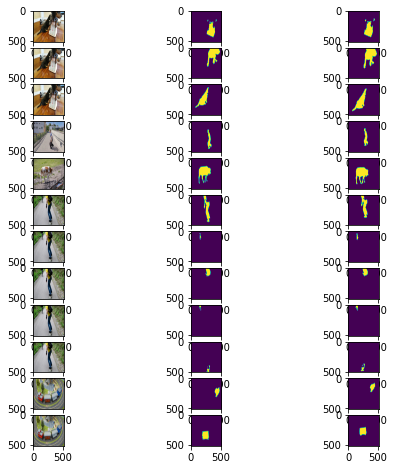

In [ ]:
f, ax = plt.subplots(batch_size, 3, figsize=(8, 8))
for i in range(batch_size):
  ax[i][0].imshow(batch_image_stack[i])
  ax[i][1].imshow(batch_mask_stack[i])
  ax[i][2].imshow(batch_aug_mask_stack[i])

In [17]:
def make_dirs(path):
  if not os.path.exists(path):
    os.makedirs(path)
  
def change_path(path, original_folder, replace_folder, data_type, counter=None, save_np=False):
  path = path.replace('data/DAVIS2017-master', data_type)
  path = path.replace(original_folder, replace_folder)
  folder_name = os.path.dirname(path)
  file_name = os.path.basename(path)
  make_dirs(folder_name)
  if counter:
    new_file_name = '{}_{}.{}'.format(file_name.split('.')[0], 
                                      str(counter).zfill(6), 
                                      file_name.split('.')[-1])
  else:
    new_file_name = '{}.{}'.format(file_name.split('.')[0], 
                                   file_name.split('.')[-1])
  dest_path = os.path.join(folder_name, new_file_name)
  if not save_np:
    return dest_path.replace('.png', '.jpg')
  else:
    return dest_path.replace('.png', '.npy').replace('.jpg', '.npy')

In [18]:
def generate_data(image_path, mask_path, target_size, augmentations_per_image, data_type):
  image_path_list = []
  mask_path_list = []
  aug_mask_path_list = []
  image_dest_path = change_path(image_path, 'Train', 'images', data_type)
  img = cv2.imread(image_path)[:,:,::-1]
  img = cv2.resize(img, (target_size[1], target_size[0]))
  cv2.imwrite(image_dest_path, img)
  mask = cv2.imread(mask_path)[:,:,::-1]
  unique = get_unique(mask)
  individual_masks = get_individual_masks_updated(unique, mask)
  for mask_counter, individual_mask in enumerate(individual_masks):
    mask_dest_path = change_path(mask_path, 'Train_Annotated', 'masks', 
                                 data_type, mask_counter + 1, True)
    individual_2d_mask = convert_mask_updated(individual_mask)
    individual_2d_mask = cv2.resize(individual_2d_mask, (target_size[1], target_size[0]))
    cv2.imwrite(mask_dest_path.replace('.npy', '.png'), individual_2d_mask)
    for augmentation_counter in range(augmentations_per_image):
      aug_mask_dest_path = change_path(mask_dest_path, 'masks', 'augmented_masks', 
                                       data_type, augmentation_counter + 1, True)
      aug_mask = augmentation(individual_mask)
      aug_2d_mask = convert_mask_updated(aug_mask)
      aug_2d_mask = cv2.resize(aug_2d_mask, (target_size[1], target_size[0]))
      cv2.imwrite(aug_mask_dest_path.replace('.npy', '.png'), aug_2d_mask)
      image_path_list.append(image_dest_path)
      mask_path_list.append(mask_dest_path)
      aug_mask_path_list.append(aug_mask_dest_path)
  return image_path_list, mask_path_list, aug_mask_path_list

In [ ]:
train_img = []
train_mask = []
train_aug_mask = []
for i in tqdm(range(len(train_image_paths))):
  image_path_list, mask_path_list, aug_mask_path_list = generate_data(train_image_paths[i], train_mask_paths[i], 
                                                                      target_size, augmentations_per_image, 'train_data')
  train_img.extend(image_path_list)
  train_mask.extend(mask_path_list)
  train_aug_mask.extend(aug_mask_path_list)

In [ ]:
train_df = pd.DataFrame({'image_paths': train_img, 'mask_paths': train_mask, 'aug_mask_paths': train_aug_mask})
train_df.to_csv('train_data_updated.csv', index=False, header=True)

In [ ]:
val_img = []
val_mask = []
val_aug_mask = []
for i in tqdm(range(len(val_image_paths))):
  image_path_list, mask_path_list, aug_mask_path_list = generate_data(val_image_paths[i], val_mask_paths[i], 
                                                                      target_size, 1, 'val_data')
  val_img.extend(image_path_list)
  val_mask.extend(mask_path_list)
  val_aug_mask.extend(aug_mask_path_list)

100%|██████████| 142/142 [04:32<00:00,  1.92s/it]


In [ ]:
val_df = pd.DataFrame({'image_paths': val_img, 'mask_paths': val_mask, 'aug_mask_paths': val_aug_mask})
val_df.to_csv('val_data.csv', index=False, header=True)

In [19]:
train_df = pd.read_csv('/content/train_data_updated.csv')
val_df = pd.read_csv('/content/val_data.csv')
val_df = val_df.replace({'.npy': '.png'}, regex=True)

In [20]:
def custom_generator(batch_size, data_df):
  spe = int(len(data_df) // batch_size)
  data_df = data_df.head(spe*batch_size)
  i = 0
  while True:
    x1_value = []
    x2_value = []
    y_value = []
    for index in range(batch_size):
      if i == len(data_df):
        i = 0
        data_df = data_df.sample(frac=1).reset_index(drop=True)
      img = cv2.imread(data_df.loc[i, 'image_paths'])[:,:,::-1].astype(np.float32)
      mask = cv2.imread(data_df.loc[i, 'mask_paths'], 0).astype(np.float32)
      aug_mask = cv2.imread(data_df.loc[i, 'aug_mask_paths'], 0).astype(np.float32)
      i += 1
      x1_value.append(img)
      x2_value.append(np.expand_dims(aug_mask, axis=-1))
      y_value.append(np.expand_dims(mask, axis=-1))
    image_batch = np.array(x1_value) / 255.0
    aug_mask_batch = np.array(x2_value)
    mask_batch = np.array(y_value)
    yield [image_batch, aug_mask_batch], mask_batch

In [ ]:
train_generator = custom_generator(batch_size, train_df)
valid_generator = custom_generator(batch_size, val_df)

In [ ]:
a, b = next(valid_generator)

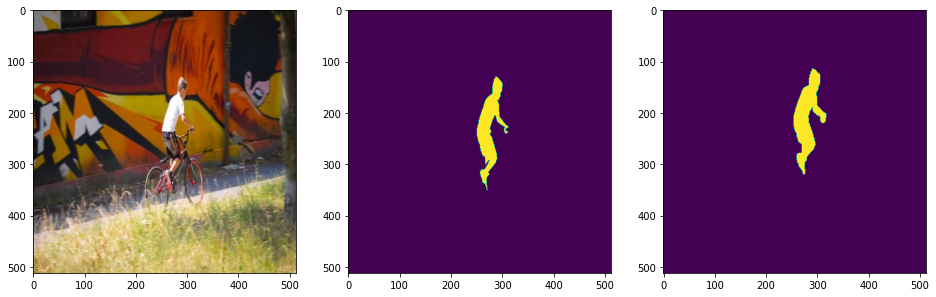

In [ ]:
f, ax = plt.subplots(1, 3, figsize=(16, 16))
ax[0].imshow(a[0][0])
ax[1].imshow(np.squeeze(b[0]))
ax[2].imshow(np.squeeze(a[1][0]))

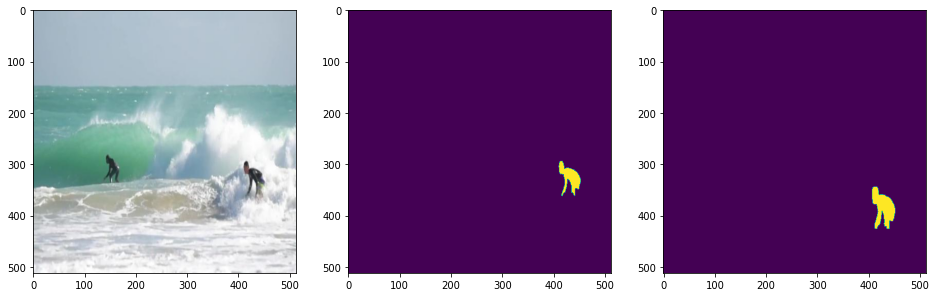

In [ ]:
f, ax = plt.subplots(1, 3, figsize=(16, 16))
ax[0].imshow(cv2.imread(val_df.loc[202, 'image_paths'])[:,:,::-1])
ax[1].imshow(cv2.imread(val_df.loc[202, 'mask_paths'], 0))
ax[2].imshow(cv2.imread(val_df.loc[202, 'aug_mask_paths'], 0))

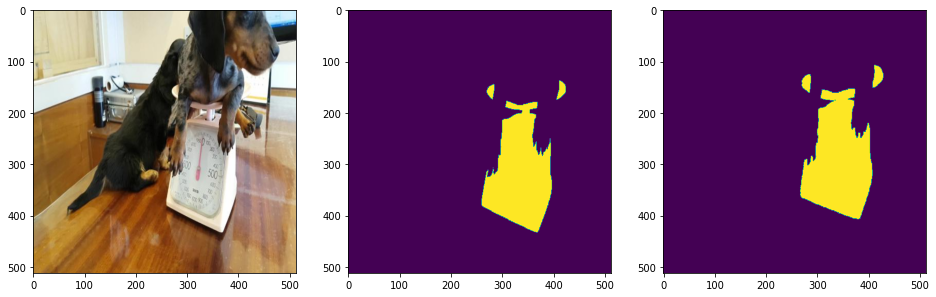

In [ ]:
c, d = next(train_generator)
f, ax = plt.subplots(1, 3, figsize=(16, 16))
ax[0].imshow(c[0][0])
ax[1].imshow(np.squeeze(d[0]))
ax[2].imshow(np.squeeze(c[1][0]))

In [22]:
class CyclicLR(Callback):

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

In [21]:
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return (1 - dice_coef(y_true, y_pred))

In [ ]:
train_generator = custom_generator(batch_size, train_df)
valid_generator = custom_generator(batch_size, val_df)

In [ ]:
offline_model = get_unet()
offline_model.compile(optimizer = RMSprop(learning_rate = 1e-4), 
                      loss=dice_coef_loss, 
                      metrics=[dice_coef])

spe = int(len(train_df) // batch_size)
vs = int(len(val_df) // batch_size)

clr = CyclicLR(base_lr=0.00001, max_lr=0.01, 
               step_size=2000 , mode='triangular2')

my_cb = [ModelCheckpoint(filepath='/content/models_offline/model-{epoch:04d}-{val_loss:.3f}.h5'),
         clr]
make_dirs('/content/models_offline')

In [ ]:
history = offline_model.fit_generator(train_generator, 
                                      steps_per_epoch=spe, 
                                      epochs=4, 
                                      callbacks=my_cb, 
                                      validation_data=valid_generator, 
                                      validation_steps=vs)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/4
3271/3271 [==============================] - 5729s 2s/step - loss: 0.3824 - dice_coef: 0.6176 - val_loss: 0.4695 - val_dice_coef: 0.5305
Epoch 2/4
3271/3271 [==============================] - 5712s 2s/step - loss: 0.2693 - dice_coef: 0.7307 - val_loss: 0.2836 - val_dice_coef: 0.7164
Epoch 3/4
3271/3271 [==============================] - 5717s 2s/step - loss: 0.2497 - dice_coef: 0.7503 - val_loss: 0.2760 - val_dice_coef: 0.7240
Epoch 4/4
 180/3271 [>.............................] - ETA: 1:30:32 - loss: 0.2466 - dice_coef: 0.7534

In [23]:
best_offline_model_path = '/content/model-0003-0.276.h5'
best_model = load_model(best_offline_model_path, custom_objects={'dice_coef_loss':dice_coef_loss,
                                                                 'dice_coef': dice_coef})

In [107]:
test_image_folder = val_image_sets[2]
test_mask_folder = val_mask_sets[2]
test_images = sorted(glob.glob(test_image_folder + '/*'))
test_masks = sorted(glob.glob(test_mask_folder + '/*'))
online_image_path = test_images[0]
online_mask_path = test_masks[0]

In [108]:
test_mask_00 = cv2.imread(test_masks[0])[:,:,::-1]
test_image_00 = cv2.imread(test_images[1])[:,:,::-1] / 255.0
test_image_00 = cv2.resize(test_image_00, (target_size[1], target_size[0]))

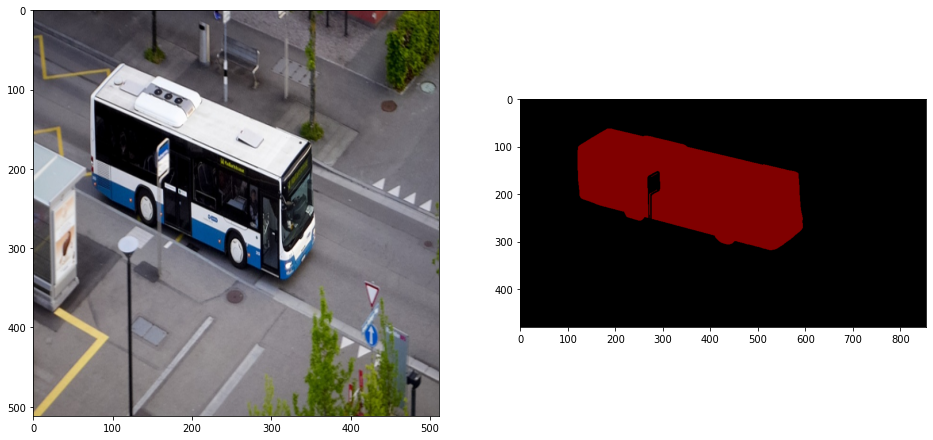

In [109]:
f, ax = plt.subplots(1, 2, figsize=(16, 16))
ax[0].imshow(test_image_00)
ax[1].imshow(test_mask_00)

In [110]:
unique = get_unique(test_mask_00)
predictions = []
individual_masks_00 = get_individual_masks_updated(unique, test_mask_00)
test_image_00 = np.expand_dims(test_image_00, axis=0)
for individual_mask in individual_masks_00:
  individual_dilated_mask = dilation(individual_mask)
  individual_2d_mask = convert_mask_updated(individual_dilated_mask)
  individual_2d_mask = cv2.resize(individual_2d_mask, (target_size[1], target_size[0]))
  individual_2d_mask = np.expand_dims(individual_2d_mask, axis=-1)
  individual_2d_mask = np.expand_dims(individual_2d_mask, axis=0)
  result = best_model.predict([test_image_00, individual_2d_mask])
  predictions.append(result)

In [111]:
predictions = [np.squeeze(prediction) for prediction in predictions]
predictions_updated = []
for prediction in predictions:
  prediction[prediction >= 0.1] = 1
  prediction[prediction < 0.1] = 0
  predictions_updated.append(prediction)

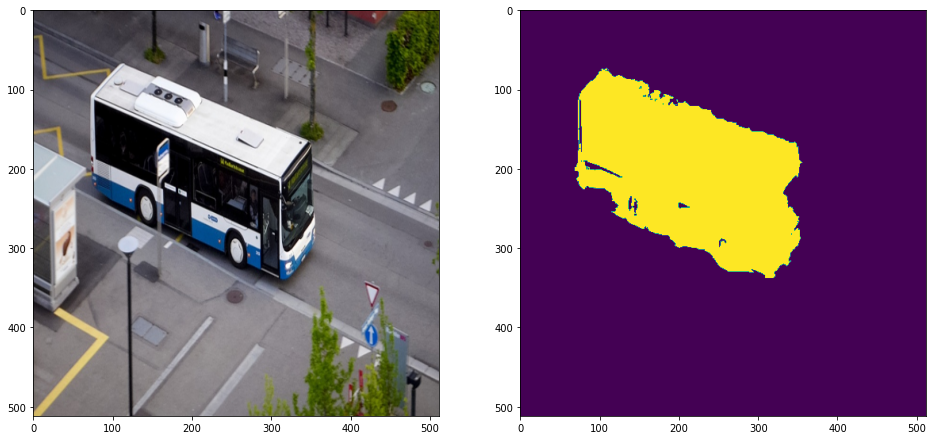

In [112]:
f, ax = plt.subplots(1, 1+len(individual_masks_00), figsize=(16, 16))
ax[0].imshow(np.squeeze(test_image_00))
for i in range(len(predictions_updated)):
  ax[i+1].imshow(predictions_updated[i])

In [ ]:
image_path_list, mask_path_list, aug_mask_path_list = generate_data(online_image_path, online_mask_path, 
                                                                    target_size, 250, 'online_training')

In [ ]:
online_df = pd.DataFrame({'image_paths': image_path_list, 
                          'mask_paths': mask_path_list, 
                          'aug_mask_paths': aug_mask_path_list})
online_df.to_csv('online_data.csv', index=False, header=True)

In [ ]:
online_df = online_df.replace({'.npy': '.png'}, regex=True)

In [ ]:
online_generator = custom_generator(batch_size, online_df)

In [ ]:
best_model.compile(optimizer = RMSprop(learning_rate = 1e-4), 
                   loss=dice_coef_loss, 
                   metrics=[dice_coef])
spe = int(len(online_df) // batch_size)

In [ ]:
best_model.fit_generator(online_generator, 
                         steps_per_epoch=spe, 
                         epochs=5)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
20/20 [==============================] - 1345s 67s/step - loss: 0.1445 - dice_coef: 0.8555
Epoch 2/5
20/20 [==============================] - 1343s 67s/step - loss: 0.1233 - dice_coef: 0.8767
Epoch 3/5
20/20 [==============================] - 1350s 68s/step - loss: 0.1072 - dice_coef: 0.8928
Epoch 4/5
 1/20 [>.............................] - ETA: 21:05 - loss: 0.0935 - dice_coef: 0.9065

KeyboardInterrupt: ignored

In [ ]:
online_mask = cv2.imread(online_mask_path)[:,:,::-1]
unique = get_unique(online_mask)
unique = np.array([a for a in list(unique) if not (a == np.array([0, 0, 0])).all()])
unique_dict = {i+1:unique_pixel for i, unique_pixel in enumerate(unique)}
unique_dict[0] = np.array([0, 0, 0]).astype(np.uint8)
get_output = []
max_output = []
for i in tqdm(range(len(test_images) - 1)):
  empty_mask = np.zeros((target_size[0], target_size[1], 3))
  current_image = cv2.imread(test_images[i+1])[:,:,::-1] / 255.0
  current_image = cv2.resize(current_image, (target_size[1], target_size[0]))
  output = np.zeros((target_size[0], target_size[1], len(unique) + 1)).astype(np.float32)
  if i == 0:
    previous_mask = online_mask.copy()
  else:
    previous_mask = get_output[-1]
  individual_masks = get_individual_masks_updated(unique, previous_mask)
  test_image = np.expand_dims(current_image, axis=0)
  predictions = []
  for j, individual_mask in enumerate(individual_masks):
    if not (individual_mask == 0).all():
      individual_dilated_mask = dilation(individual_mask)
      individual_2d_mask = convert_mask_updated(individual_dilated_mask)
      individual_2d_mask = cv2.resize(individual_2d_mask, (target_size[1], target_size[0]))
      individual_2d_mask = np.expand_dims(individual_2d_mask, axis=-1)
      individual_2d_mask = np.expand_dims(individual_2d_mask, axis=0)
      result = best_model.predict([test_image, individual_2d_mask])
      result = np.squeeze(result)
      result[result < 0.8] = 0
      output[:, :, j + 1] = result
    else:
      output[:, :, j + 1] = np.zeros((target_size[0], target_size[1]))
  max_classes = np.argmax(output, axis=-1)
  max_output.append(max_classes)
  for k in range(max_classes.shape[0]):
    for l in range(max_classes.shape[1]):
      empty_mask[k, l, :] = unique_dict[max_classes[k, l]]
  get_output.append(empty_mask)

In [159]:
get_output = [a.astype(np.uint8) for a in get_output]
imageio.mimsave('output_movie.gif', get_output)

In [ ]:
Image(open('output_movie.gif','rb').read())

In [161]:
def get_gt_mask(gt, rev_dict):
  gt = gt / 128.0
  gt = gt.astype(np.uint8)
  gt = cv2.resize(gt, (target_size[1], target_size[0]))
  gt_2d_mask = np.zeros(target_size, dtype=np.uint8)
  for i in range(gt.shape[0]):
    for j in range(gt.shape[1]):
      gt_2d_mask[i, j] = rev_dict[tuple(a * 128 for a in tuple(gt[i, j, :]))]
  return gt_2d_mask

In [162]:
rev_dict = {tuple(v):k for k, v in unique_dict.items()}
gts = [cv2.imread(x)[:,:,::-1] for x in test_masks[1:]]

In [163]:
gt_masks = [get_gt_mask(gt, rev_dict) for gt in gts]

In [195]:
def dice_coef_metric(y_true, y_pred):
  y_true_f = y_true.flatten()
  y_pred_f = y_pred.flatten()
  intersection = np.sum(y_true_f * y_pred_f)
  smooth = 0.0001
  return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def dice_coef_multilabel(y_true, y_pred, numLabels):
  dice={}
  for index in range(numLabels):
    dice[index] = dice_coef_metric(y_true[:,:,:,index], y_pred[:,:,:,index])
  return dice

In [191]:
gt_masks = np.array(gt_masks)
max_output = np.array(max_output)
n_labels = len(np.unique(max_output))

In [196]:
y_true = to_categorical(gt_masks, n_labels)
y_pred = to_categorical(max_output, n_labels)
dice = dice_coef_multilabel(y_true, y_pred, n_labels)

In [197]:
dice

{0: 0.9527009076960062, 1: 0.7251092634925486}